In [1]:
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from pycocotools.coco import COCO
import numpy as np
from PIL import Image  # For loading images
from skimage import color
from torch.utils.data import DataLoader

In [2]:
import os
import sys

current_dir = os.path.dirname(os.path.abspath(os.getcwd()))
src_dir = os.path.join(current_dir, "src")
sys.path.append(current_dir)
sys.path.append(src_dir)

from src.dataloaders.colorization_dataset import ColorizationDataset  # noqa
from src.utils.colorization_utils import ColorizationUtils  # noqa

In [3]:
sns.set_theme(style="whitegrid")
sns.set_context("talk")

In [4]:
# Data can be downloaded from
# https://www.kaggle.com/datasets/awsaf49/coco-2017-dataset/data


data_folder = "../data"
train_folder = f"{data_folder}/train2017"
val_folder = f"{data_folder}/val2017"
annFile = f"{data_folder}/annotations/instances_train2017.json"
train_dataset = datasets.CocoDetection(root=train_folder, annFile=annFile)

loading annotations into memory...
Done (t=3.03s)
creating index...
index created!


In [ ]:
coco = COCO(annFile)

# Get all image ids
imgIds = coco.getImgIds()
images_info = coco.loadImgs(imgIds)

# Extract sizes
image_sizes = [(img["width"], img["height"]) for img in tqdm(images_info)]

loading annotations into memory...


In [ ]:
size_df = pd.DataFrame(image_sizes, columns=["Width", "Height"])
size_df["combined"] = size_df["Width"].astype(str) + "x" + size_df["Height"].astype(str)
dimension_counts = size_df["combined"].value_counts()
dimension_counts_filtered = dimension_counts[dimension_counts > 500]

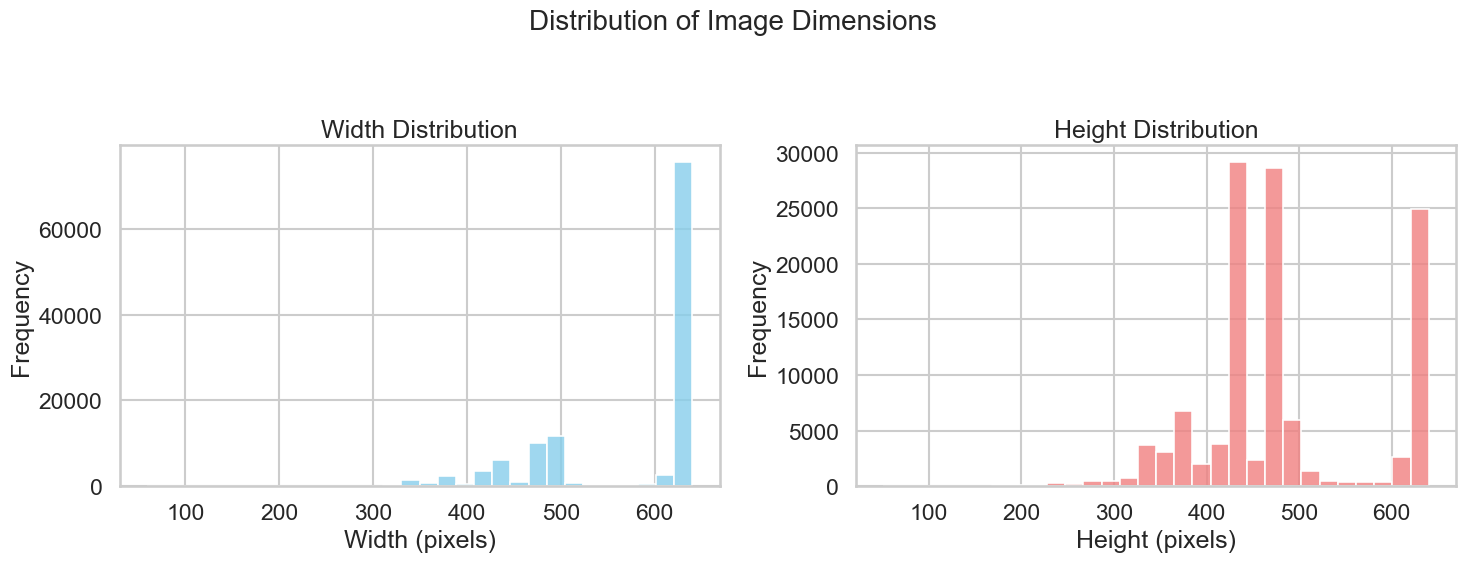


Image Dimension Statistics:
               Width         Height
count  118287.000000  118287.000000
mean      577.712065     484.098895
std        91.884340      97.089573
min        59.000000      51.000000
25%       500.000000     426.000000
50%       640.000000     480.000000
75%       640.000000     513.000000
max       640.000000     640.000000


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Slightly wider figure
fig.suptitle("Distribution of Image Dimensions", fontsize=20)  # Larger title

# Width distribution
sns.histplot(
    size_df["Width"],
    bins=30,
    ax=axes[0],
    color="skyblue",  # Use defined color
    edgecolor="white",  # Add edge color for definition
    alpha=0.8,  # Add some transparency
)
axes[0].set_title("Width Distribution")
axes[0].set_xlabel("Width (pixels)")
axes[0].set_ylabel("Frequency")

# Height distribution
sns.histplot(
    size_df["Height"],
    bins=30,
    ax=axes[1],
    color="lightcoral",  # Use defined color
    edgecolor="white",  # Add edge color for definition
    alpha=0.8,  # Add some transparency
)
axes[1].set_title("Height Distribution")
axes[1].set_xlabel("Height (pixels)")
axes[1].set_ylabel("Frequency")


# Adjust layout to prevent title overlap and ensure labels fit
plt.tight_layout(rect=[0, 0.03, 1, 0.93])  # Adjusted rect slightly for larger title
plt.show()

# Display basic statistics
print("\nImage Dimension Statistics:")
print(size_df.describe())

/var/folders/29/fzxxbhj56l38j_dynbppz2hr0000gn/T/ipykernel_90841/1814266124.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


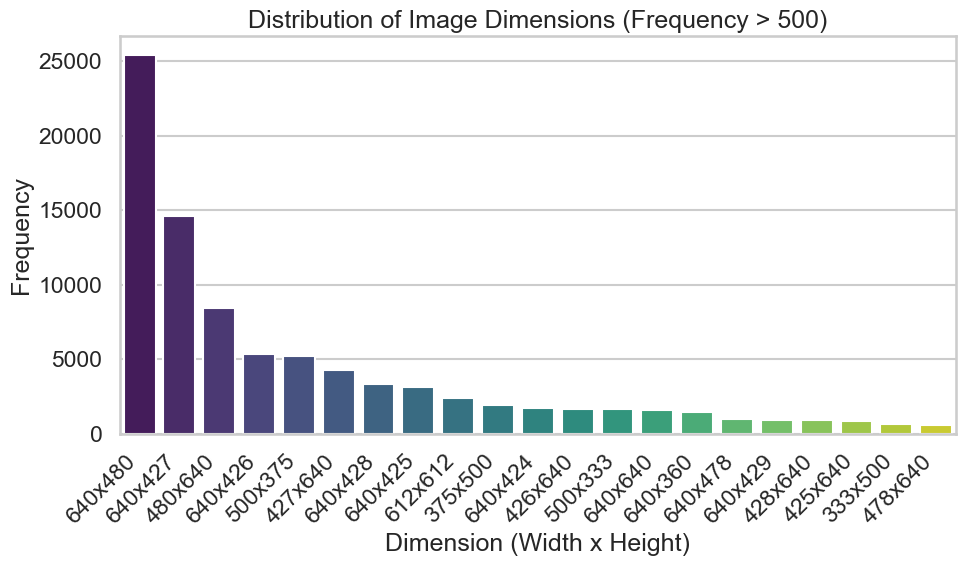

In [ ]:
plt.figure(figsize=(10, 6))
# Order bars by frequency
order = dimension_counts_filtered.index
ax = sns.barplot(
    x=dimension_counts_filtered.index,
    y=dimension_counts_filtered.values,
    order=order,
    palette="viridis",
)
plt.title("Distribution of Image Dimensions (Frequency > 500)")
plt.xlabel("Dimension (Width x Height)")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha="right")  # Rotate labels if they overlap
plt.tight_layout()
plt.show()

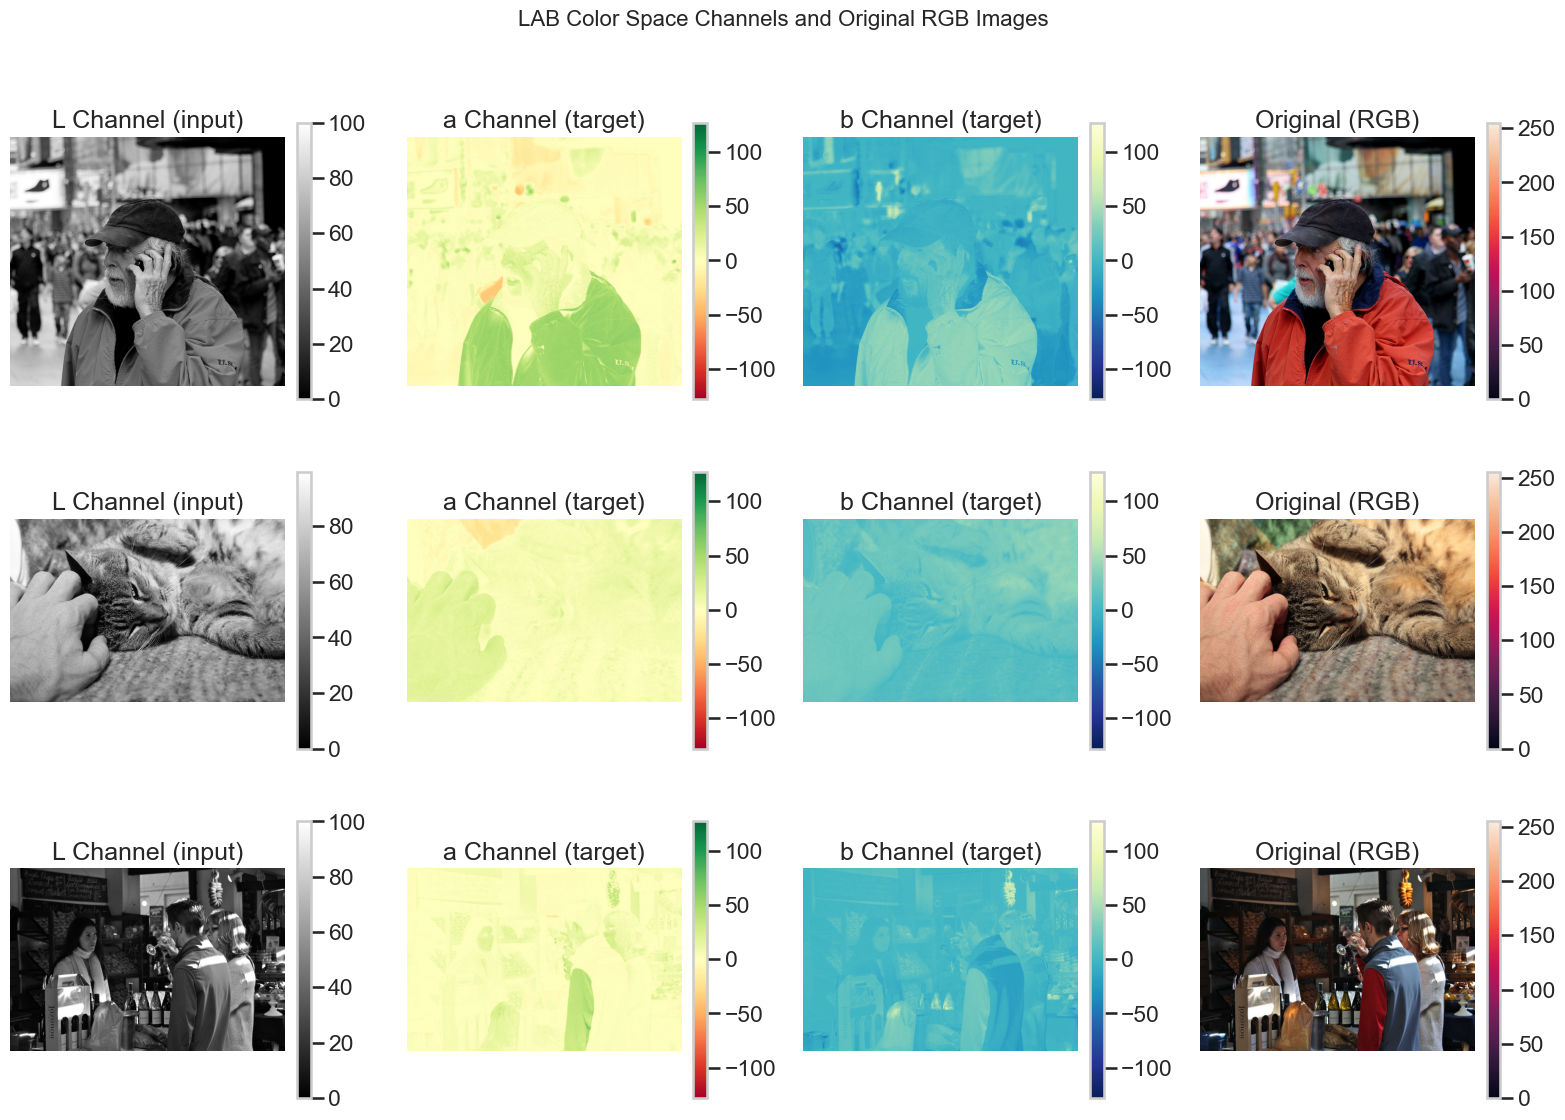

In [ ]:
image_path_1 = "../data/train2017/000000000395.jpg"
image_path_2 = "../data/train2017/000000581033.jpg"
image_path_3 = "../data/train2017/000000580945.jpg"

image_paths = [image_path_1, image_path_2, image_path_3]
img_data_list = []
img_names = ["Image 1", "Image 2", "Image 3"]

for path in image_paths:
    with Image.open(path) as img:
        img_data_list.append(np.array(img.convert("RGB")))

num_images = len(img_data_list)
fig, axes = plt.subplots(num_images, 4, figsize=(16, 4 * num_images))
fig.suptitle("LAB Color Space Channels and Original RGB Images", fontsize=16)

for i, img_data_np in enumerate(img_data_list):
    img_name = img_names[i]

    lab_img = color.rgb2lab(img_data_np)

    l_channel = lab_img[:, :, 0]
    a_channel = lab_img[:, :, 1]
    b_channel = lab_img[:, :, 2]

    im_l = axes[i, 0].imshow(l_channel, cmap="gray")
    axes[i, 0].set_title("L Channel (input)")
    axes[i, 0].axis("off")
    fig.colorbar(im_l, ax=axes[i, 0], fraction=0.046, pad=0.04)

    im_a = axes[i, 1].imshow(a_channel, cmap="RdYlGn", vmin=-128, vmax=127)
    axes[i, 1].set_title("a Channel (target)")
    axes[i, 1].axis("off")
    fig.colorbar(im_a, ax=axes[i, 1], fraction=0.046, pad=0.04)

    im_b = axes[i, 2].imshow(b_channel, cmap="YlGnBu_r", vmin=-128, vmax=127)
    axes[i, 2].set_title("b Channel (target)")
    axes[i, 2].axis("off")
    fig.colorbar(im_b, ax=axes[i, 2], fraction=0.046, pad=0.04)

    im_orig = axes[i, 3].imshow(img_data_np, vmin=0, vmax=255)
    axes[i, 3].set_title("Original (RGB)")
    axes[i, 3].axis("off")
    fig.colorbar(im_orig, ax=axes[i, 3], fraction=0.046, pad=0.04)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

In [ ]:
TARGET_IMAGE_SIZE = (256, 256)
BATCH_SIZE: int = 32
TARGET_SAMPLE_COUNT: int = 1000
train_dataset: ColorizationDataset = ColorizationDataset(
    root_dir=train_folder, target_size=TARGET_IMAGE_SIZE
)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"\nTotal training images found: {len(train_dataset)}")

print(f"\nCollecting A and B channel data for ~{TARGET_SAMPLE_COUNT} samples...")

all_a_values = []
all_b_values = []
total_samples_processed = 0

for i, (inputs, targets) in enumerate(train_loader):
    current_batch_size = targets.shape[0]

    # Extract A and B channels (shape: batch, H, W)
    a_batch_normalized = targets[:, 0, :, :]
    b_batch_normalized = targets[:, 1, :, :]

    # De-normalize A and B channels to [-128, 127]
    a_batch_denorm = a_batch_normalized * ColorizationUtils.AB_SCALE
    b_batch_denorm = b_batch_normalized * ColorizationUtils.AB_SCALE

    all_a_values.extend(a_batch_denorm.detach().cpu().numpy().flatten())
    all_b_values.extend(b_batch_denorm.detach().cpu().numpy().flatten())

    total_samples_processed += current_batch_size
    print(f"  Processed {total_samples_processed} samples...", end="\r")

    if total_samples_processed >= TARGET_SAMPLE_COUNT:
        break


Total training images found: 118287



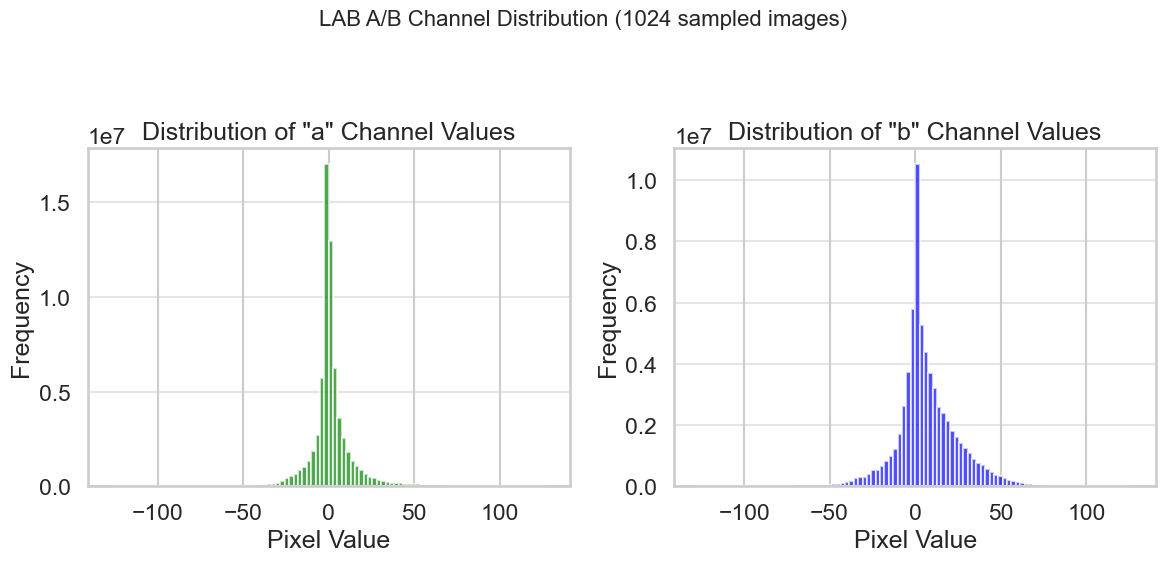

In [ ]:
all_a_values_np = np.array(all_a_values)
all_b_values_np = np.array(all_b_values)

plt.figure(figsize=(12, 6))

# Histogram for 'a' channel
plt.subplot(1, 2, 1)
plt.hist(all_a_values_np, bins=100, range=(-128, 128), color="green", alpha=0.7)
plt.title('Distribution of "a" Channel Values')
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.5)

# Histogram for 'b' channel
plt.subplot(1, 2, 2)
plt.hist(all_b_values_np, bins=100, range=(-128, 128), color="blue", alpha=0.7)
plt.title('Distribution of "b" Channel Values')
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.5)

plt.suptitle(
    f"LAB A/B Channel Distribution ({total_samples_processed} sampled images)",
    fontsize=16,
)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

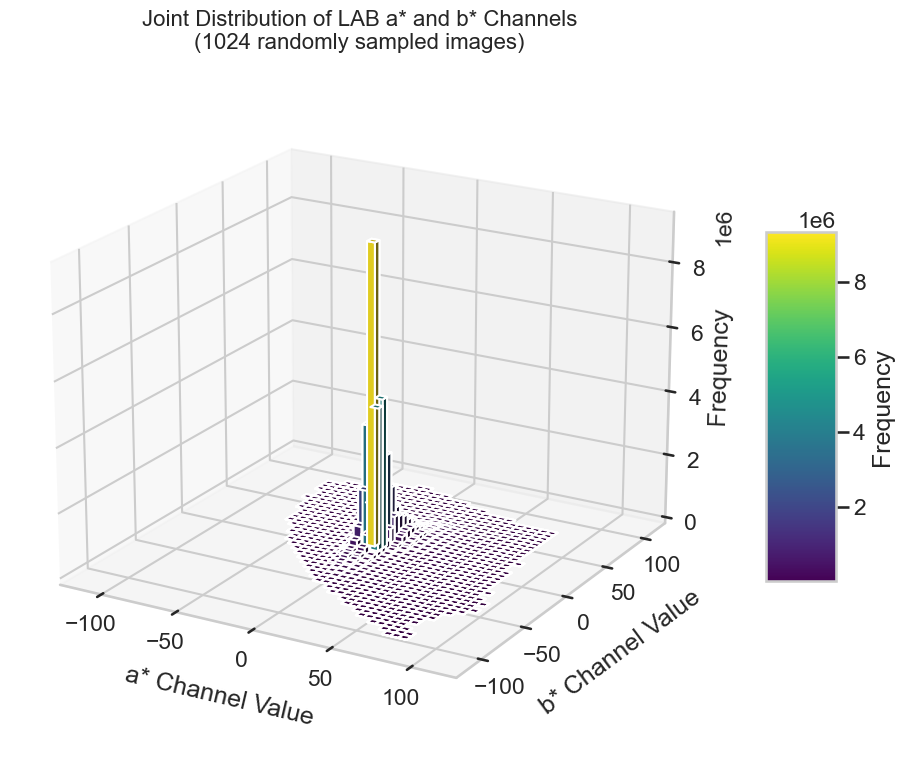

In [ ]:
bins = 50
hist_range = [[-128, 128], [-128, 128]]
hist, xedges, yedges = np.histogram2d(
    all_a_values_np, all_b_values_np, bins=bins, range=hist_range
)

xpos, ypos = np.meshgrid(
    xedges[:-1] + (xedges[1] - xedges[0]) / 2,
    yedges[:-1] + (yedges[1] - yedges[0]) / 2,
    indexing="ij",
)
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

dz = hist.ravel()
dx = dy = (xedges[1] - xedges[0]) * np.ones_like(dz)

mask = dz > 0
xpos = xpos[mask]
ypos = ypos[mask]
dz = dz[mask]
dx = dx[mask]
dy = dy[mask]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

colors = plt.cm.viridis(dz / np.max(dz))
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort="average", color=colors)

norm = plt.Normalize(dz.min(), dz.max())

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, shrink=0.5, aspect=5, label="Frequency")


ax.set_xlabel("a* Channel Value", labelpad=15)
ax.set_ylabel("b* Channel Value", labelpad=15)
ax.set_zlabel("Frequency", labelpad=1)

title_text = "Joint Distribution of LAB a* and b* Channels"
title_text += f"\n({total_samples_processed} randomly sampled images)"
ax.set_title(title_text, fontsize=16)

ax.set_xlim([-128, 128])
ax.set_ylim([-128, 128])
ax.view_init(elev=20, azim=-60)

plt.tight_layout()
plt.show()